# Alan Precal

By "precal" we mean, for the default number of calibration terms (6, 5), figuring out the best S11 bias models that retrieve similar parameters to B18.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from edges_cal import modelling as mdl
from pathlib import Path

import mcmc_utils as mutl
from edges_estimate.eor_models import AbsorptionProfile
from edges_estimate.fitting import SemiLinearFit
from getdist import plots

import alan_data_utils as utils
import alan_data as adata
import glob
import run_alan_precal_mcmc as precal
from scipy import optimize
import notebook_utils as nutl
import pickle
from multiprocessing import Pool

plt.ion()

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
nutl.setup_mpl()

In [3]:
calobs16 = utils.get_calobs(smooth=16)
calobs32 = utils.get_calobs(smooth=32)

In [5]:
names = sorted(Path('outputs/alan_precal/').glob("*"))

cal_lks = {}
for name in names:
    print(name.name)
    cal_lks[name.name] = precal.get_likelihood_from_label(name.name)

smooth32_tns0500_ign[()]_sim[()]_s11('short', 'open')_nscale01_ndelay01_unw-False_cnf1
smooth32_tns0500_ign[()]_sim[()]_s11('short', 'open')_nscale01_ndelay02_unw-False_cnf1
smooth32_tns0500_ign[()]_sim[()]_s11('short', 'open')_nscale01_ndelay03_unw-False_cnf1
smooth32_tns0500_ign[()]_sim[()]_s11('short', 'open')_nscale01_ndelay04_unw-False_cnf1
smooth32_tns0500_ign[()]_sim[()]_s11('short', 'open')_nscale02_ndelay01_unw-False_cnf1
smooth32_tns0500_ign[()]_sim[()]_s11('short', 'open')_nscale02_ndelay02_unw-False_cnf1
smooth32_tns0500_ign[()]_sim[()]_s11('short', 'open')_nscale03_ndelay01_unw-False_cnf1
smooth32_tns0500_ign[()]_sim[()]_s11('short', 'open')_nscale03_ndelay03_unw-False_cnf1
smooth32_tns0500_ign[()]_sim[()]_s11('short', 'open')_nscale04_ndelay01_unw-False_cnf1
smooth32_tns0500_ign[()]_sim[()]_s11('short', 'open')_nscale04_ndelay04_unw-False_cnf1
smooth32_tns0500_ign[()]_sim[()]_s11('short', 'open', 'ambient', 'hot_load')_nscale01_ndelay01_unw-False_cnf1
smooth32_tns0500_ign

In [6]:
cal_lk_res = {}
for name in names:
    fname = name / 'bayescal.map'
    if fname.exists():
        with open(fname, 'rb') as fl:
            d = pickle.load(fl)
        cal_lk_res[name.name] = d['optres']

In [7]:
len(cal_lk_res)

16

In [8]:
curves = {
    name: cal_lks[name].get_cal_curves(res.x) for name, res in cal_lk_res.items()
}

In [9]:
recals = {}

recals['alan'] = adata.sky_data['t_ant']

for name, clb in (('Iterative', utils.calobs), ("Iterative (32ch)", calobs32)):
    recals[name] = utils.recalibrate(utils.get_labcal(clb), f_sky=adata.sky_data['freq'], t_sky=adata.sky_data['t_ant'])
    
for name, res in cal_lk_res.items():
    lk = cal_lks[name]
    a, b = lk.get_linear_coefficients(
        freq=adata.sky_freq, labcal=utils.labcal, params=res.x
    )
    recals[name] = utils.recalibrate(utils.labcal, f_sky=adata.sky_data['freq'], t_sky=adata.sky_data['t_ant'], a=a,b=b)

In [10]:
def get_slf(recal):
    linlog5 = mdl.LinLog(n_terms=5)
    return SemiLinearFit(
        fg=linlog5.at(x=adata.sky_freq), 
        eor=utils.make_absorption(adata.sky_freq),
        spectrum=recal, 
        sigma=0.03
    )
def get_features(recal):
    slf = get_slf(recal)
    return slf(dual_annealing_kw={'maxiter':200})

In [11]:
p = Pool(16)

In [12]:
# Don't change this, it's finnicky with multiprocessing.
features = dict(zip(recals.keys(), list(p.map(get_features, list(recals.values())))))
slfs = {name: get_slf(recal) for name, recal in recals.items()}

In [23]:
def plot_cal_params(filt):
    fig, ax = plt.subplots(5, 2, sharex=True, figsize=(nutl.double_width, 1.5*nutl.single_width), gridspec_kw={'hspace': 0.05, 'wspace': 0.3})

    plt.rcParams['axes.labelsize'] = 10
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 10

    ignore = []

    linestyles = ['-', '--', ':', '-.'] + [
         (0, (1, 4)),
         (0, (5, 3)),
         (2, (5, 2)),
         (0, (3, 5, 1, 5)),
         (0, (3, 1, 1, 1)),
         (0, (3, 3, 1, 3, 1, 3)),
         (1, (4, 3, 1, 3, 1, 3)),
         (0, (3, 1, 1, 1, 1, 1))
    ]

    for i, (name, model) in enumerate(list(curves.values())[0].items()):
        if name == 'params':
            continue

        if name == 'tload':
            aname = 'offset'
        elif name == 'tns':
            aname = 'scale'
        else:
            aname = name

        alans = adata.calibration[aname].copy()

        ylab = {
            'tunc': r'$T_{\rm unc}$',
            'tcos': r'$T_{\rm cos}$',
            'tsin': r'$T_{\rm sin}$',
            'tload': r'$T_{\rm L}$',
            'tns': r'$T_{\rm NS}$'
        }[name]
        ax[i, 0].text(0.8, 0.2 if i!=3 else 0.7, ylab, transform=ax[i, 0].transAxes, 
                      fontweight='heavy', backgroundcolor='white', 
                      bbox={'alpha': 0.5, 'facecolor': 'white', 'edgecolor': 'white', 'boxstyle':'round'})
        calobs_name = {
            'tunc': 'Tunc',
            'tcos': 'Tcos',
            'tsin': 'Tsin',
            'tload': 'C2',
            'tns': 'C1'
        }[name]

        v = getattr(utils.calobs, calobs_name)()
        v32 = getattr(calobs32, calobs_name)()

        if calobs_name == 'C2':
            v = utils.calobs.t_load - v
            v32 = utils.calobs.t_load - v32
            alans = utils.calobs.t_load - alans
        if calobs_name == 'C1':
            v *= utils.calobs.t_load_ns
            v32 *= utils.calobs.t_load_ns
            alans *= utils.calobs.t_load_ns

        all_curves = (('Iterative', v), ("Iterative (32ch)", v32)) + tuple(curves.items())
        for j, (lbl, crv) in enumerate(all_curves):
            if filt(lbl):
                continue

            if isinstance(crv, dict):
                m = crv[name]
            else:
                m = crv

            freq = utils.calobs.freq.freq

            if '32' in lbl:
                a = alans[::4]
                f = freq[::4].copy()
            else:
                a = alans
                f = freq.copy()

            ax[i, 0].plot(f, 100*(m - a)/a, label=lbl, ls=linestyles[j%len(linestyles)], color=f'C{j%10}')

    linlog5 = mdl.LinLog(n_terms=5)

    for i, (name, recal) in enumerate(recals.items()):
        if filt(name):
            continue

        color = 'k' if not i else f"C{(i-1)%10}"
        ls=linestyles[(i-1)%len(linestyles)] if i > 0 else '-'

        if name != 'alan':
            ax[-2, 1].plot(adata.sky_freq, recal - adata.sky_data['t_ant'], color=color, ls=ls)

        res, slf = features[name], slfs[name]
        if not res.success:
            print(i, "was not successful")

        ax[-1, 1].plot(adata.sky_freq, slf.get_eor(res.x), color=color, ls=ls, lw=4 if name=='alan' else 1.5, label='B18' if name == 'alan' else None, )

    ax[0, 1].axis('off')
    ax[1, 1].axis('off')
    ax[2, 1].axis('off')

    ax[-1, 1].set_ylabel(r"$\hat{T}_{21}$ [K]")

    # fig.text(0.04, 2.5/7, )
    #plt.annotate(r'$\Delta T / T^{\rm B18}$', va='center', rotation='vertical', xytext=(0.04, 2.5/7), xy=(0.04, 1), transform=fig.transFigure)
    ax[-2, 1].set_ylabel(r"$\Delta T_{\rm sky}$ [K]")
    ax[0, 0].legend(ncol=1, bbox_to_anchor=(1.3, 1.), loc='upper left')
    ax[-1, 1].legend(loc='lower left', frameon=False)
    ax[-1, 1].set_xlabel("Frequency [MHz]")
    ax[-1, 0].set_xlabel("Frequency [MHz]")

    fig.supylabel(r"$\Delta T / T^{\rm B18}$ [%]")

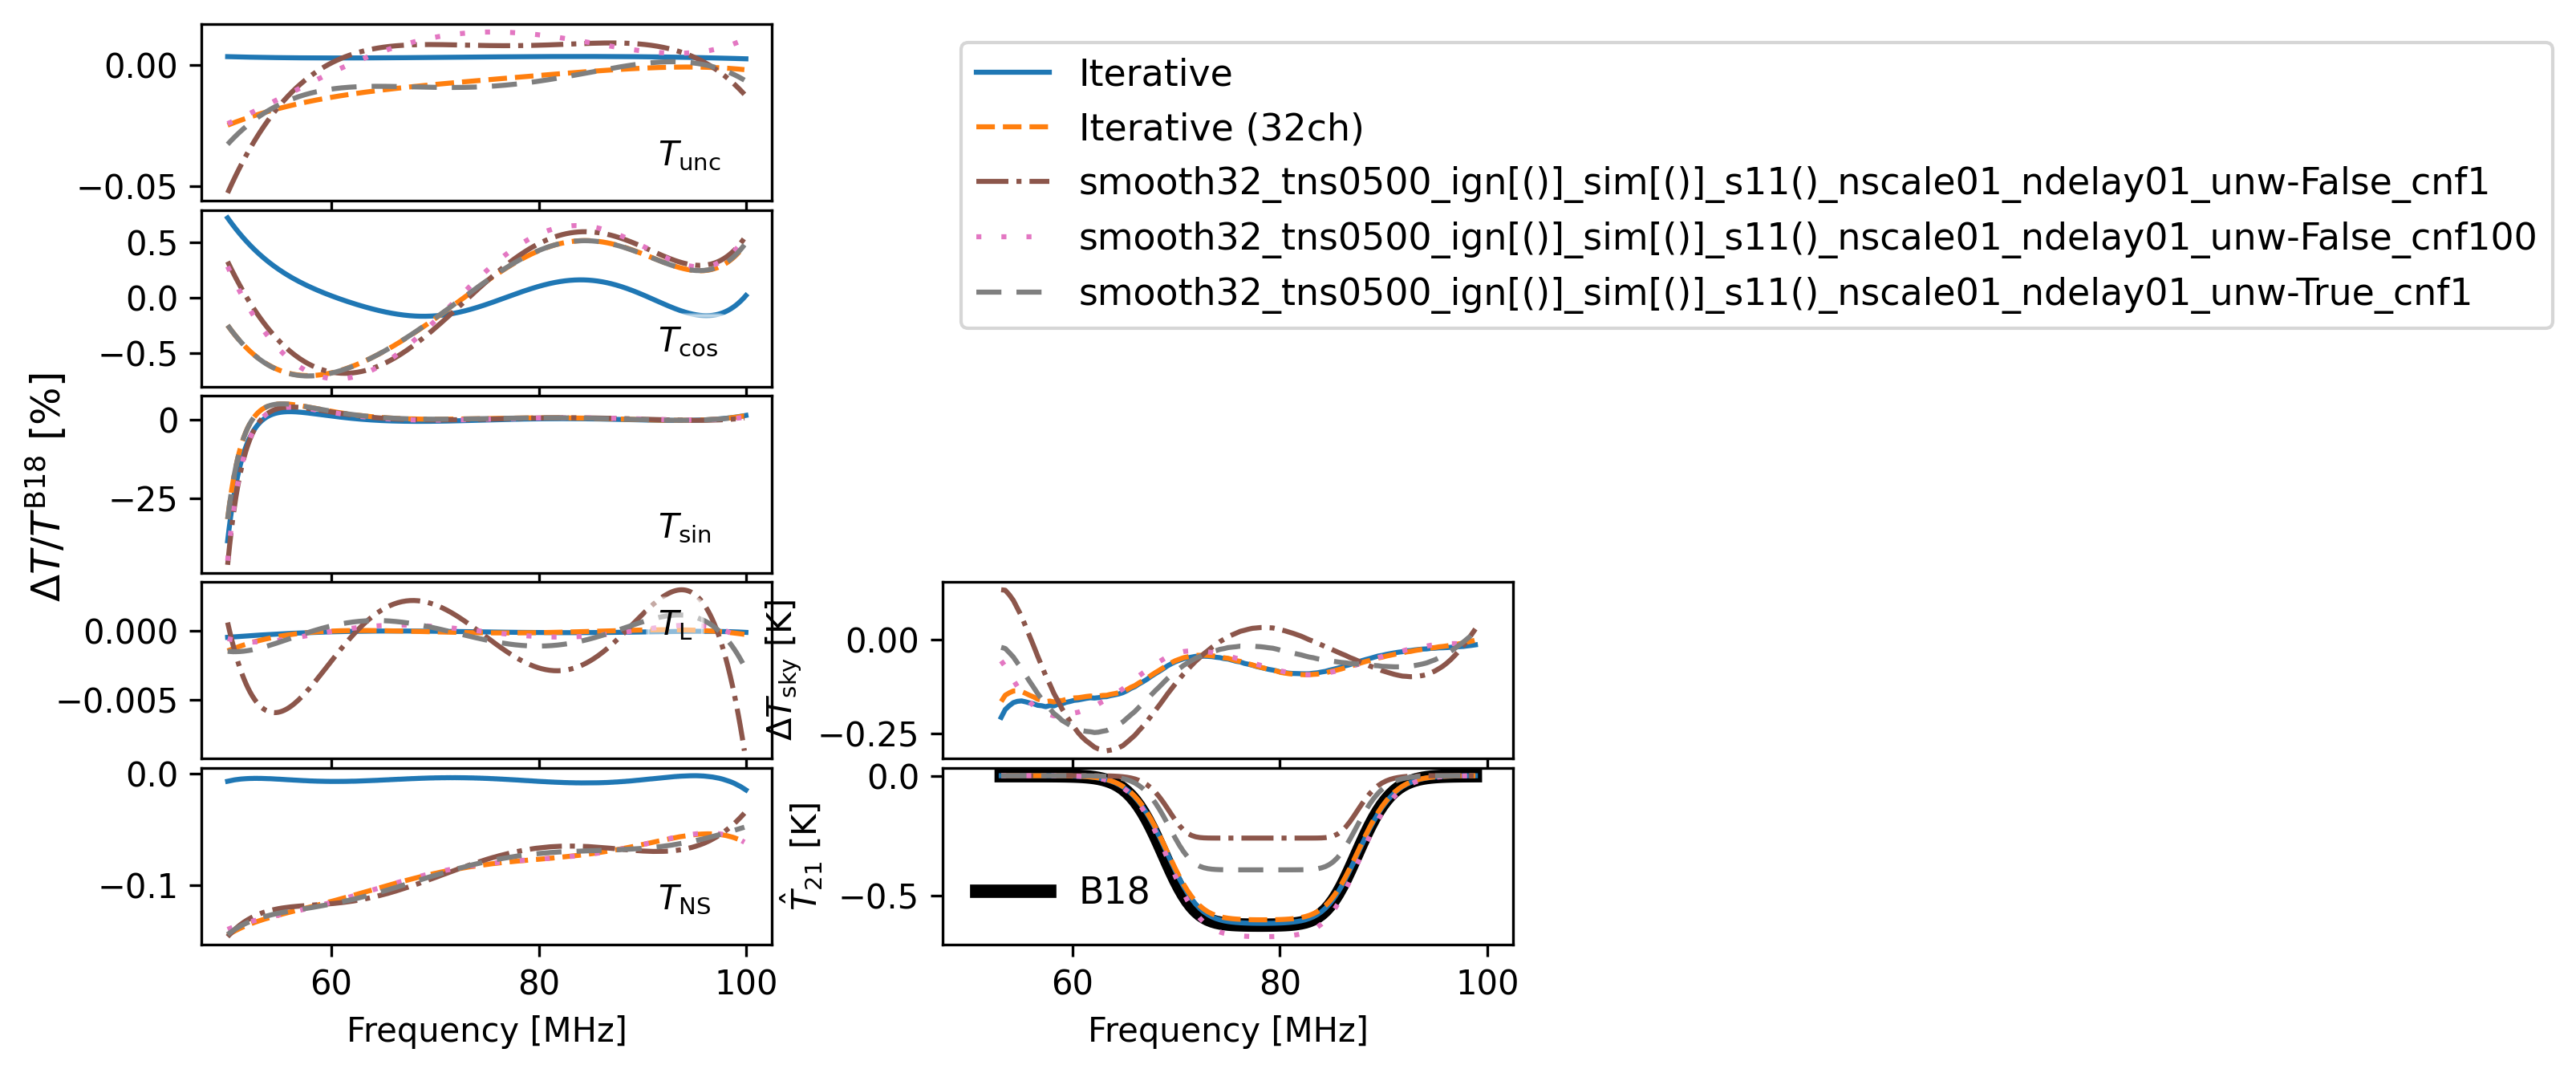

In [24]:
plot_cal_params(lambda lbl: 'short' in lbl)

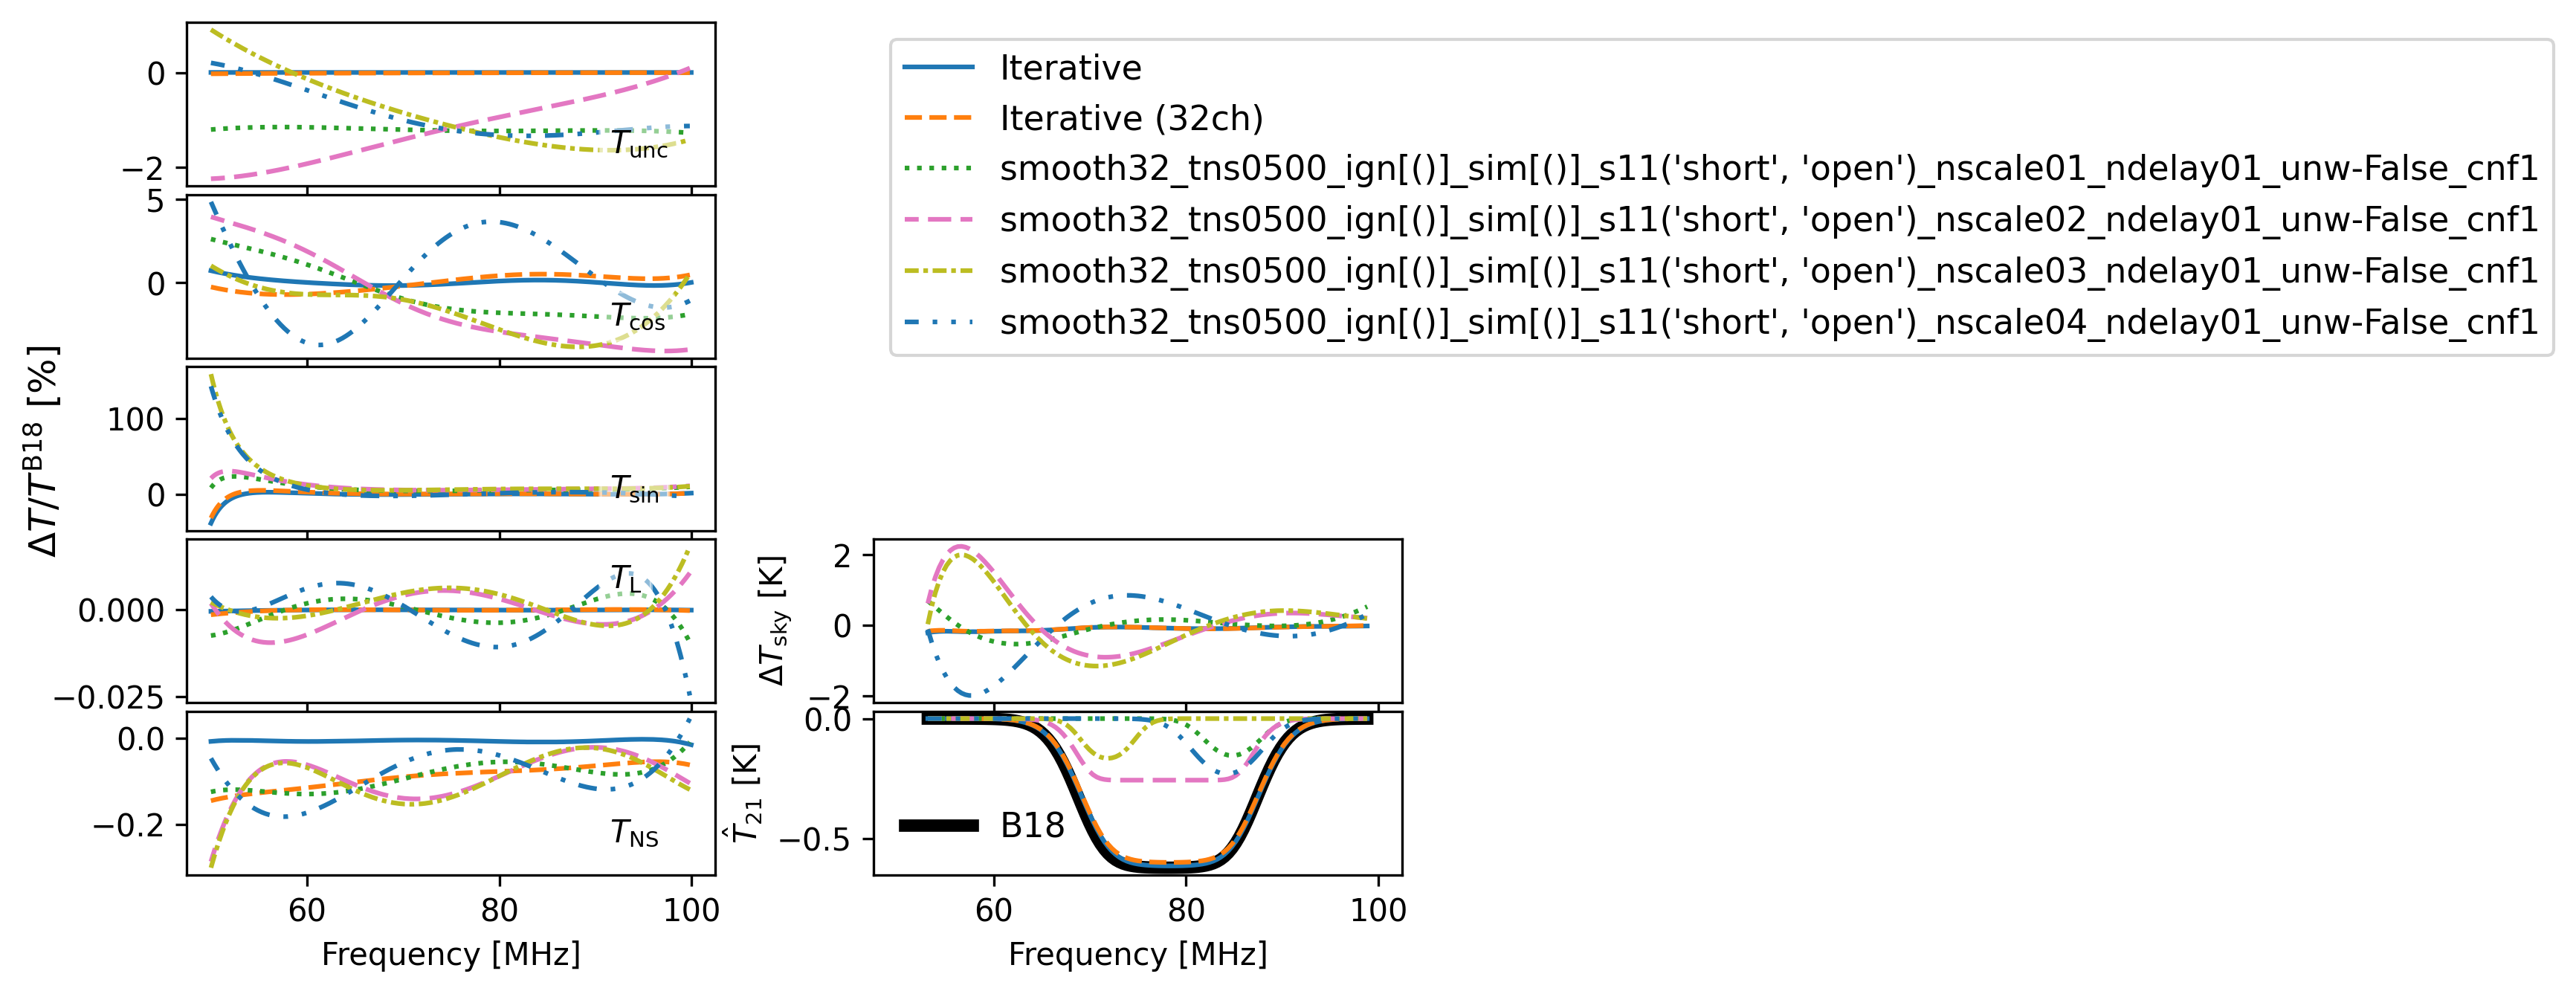

In [26]:
plot_cal_params(lambda lbl: 's11()' in lbl or 'ndelay02' in lbl or 'ndelay03' in lbl or 'ndelay04' in lbl or 'ambient' in lbl)

In [34]:
antsim = calobs32.new_load('AntSim1', io_obj = utils.calobs.metadata['io'])

In [35]:
these_loads = {**calobs32.loads, **{'antsim': antsim}}

/tmp/ipykernel_27660/3524677249.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


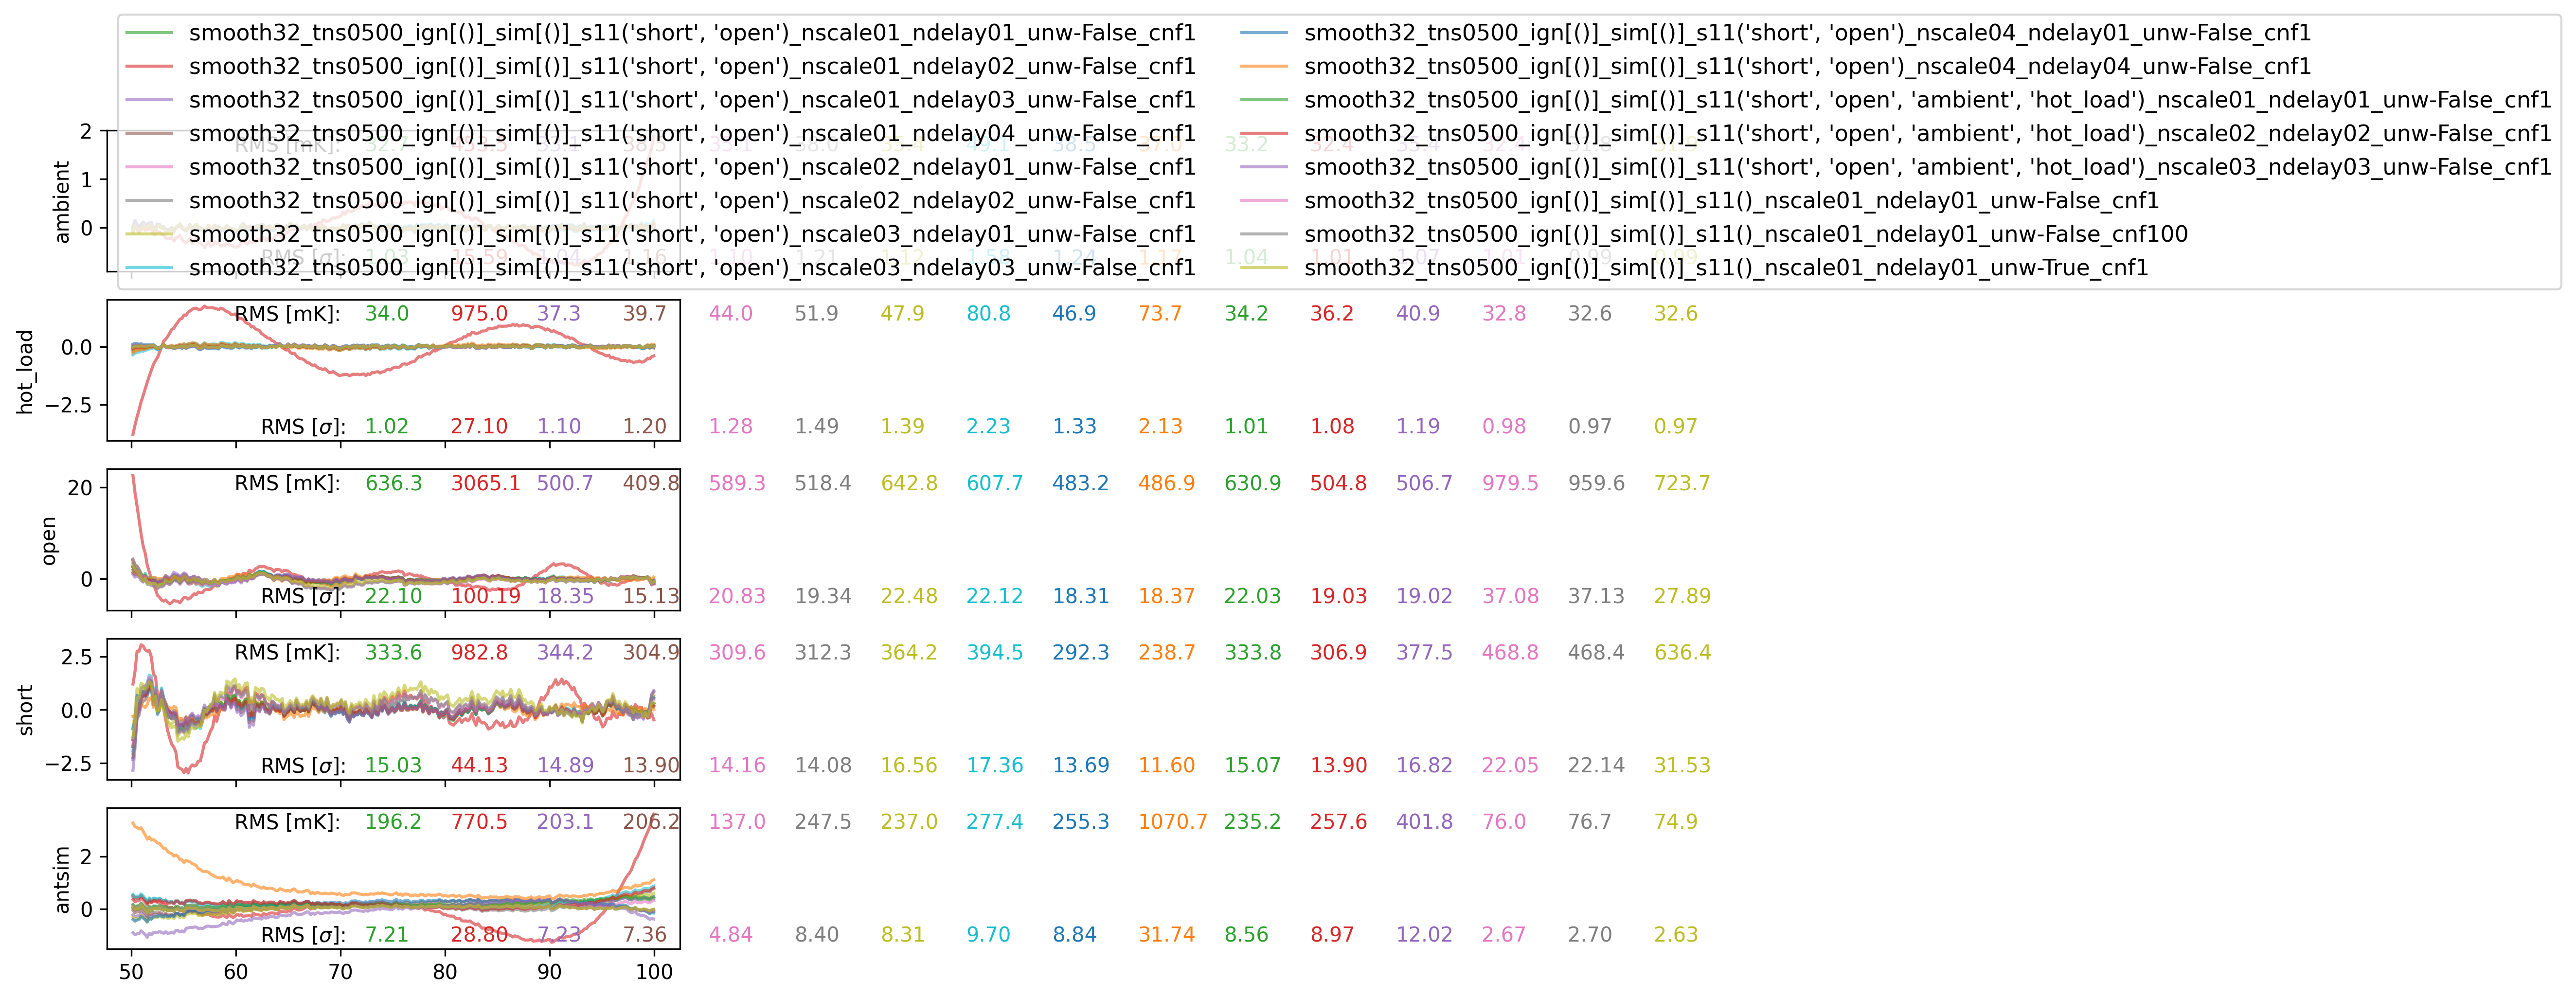

In [38]:
fig, ax = plt.subplots(5, 1, figsize=(1.5*nutl.single_width, 2.2*nutl.single_width), sharex=True)


n = 0
for j, (name, lk) in enumerate(cal_lks.items()):
    if name not in cal_lk_res:
        continue
        
    for i, (src, load) in enumerate(these_loads.items()):
        a, b = lk.get_linear_coefficients(
            freq=calobs32.freq.freq.to_value("MHz"), labcal=utils.get_labcal(calobs32), params=cal_lk_res[name].x, load=load
        )

        cal = calobs32.t_load_ns * a * load.spectrum.averaged_Q + a * 300 + b
        
        res = cal - load.temp_ave
        ax[i].plot(calobs32.freq.freq, res, label=name, alpha=0.6, color=f'C{j+2}')
        
        if j==0:
            ax[i].text(0.42, 0.85, "RMS [mK]: ", transform=ax[i].transAxes, horizontalalignment='right')
        ax[i].text(0.45 + n*0.15, 0.85, f"{np.sqrt(np.mean(np.square(res)))*1000:.1f}", color=f"C{j+2}", transform=ax[i].transAxes)
        
        tns = lk.t_ns_model.model(parameters=cal_lk_res[name].x[:calobs32.cterms])
        res2 = res / np.sqrt(load.spectrum.variance_Q / load.spectrum.n_integrations) / tns
        
        if j==0:
            ax[i].text(0.42, 0.05, "RMS [$\sigma$]: ",transform=ax[i].transAxes, horizontalalignment='right')
        ax[i].text(0.45 + n*0.15, 0.05, f"{np.sqrt(np.mean(np.square(res2))):.2f}", color=f"C{j+2}", transform=ax[i].transAxes)
            
        ax[i].set_ylabel(src)
        
    n += 1
    
ax[0].legend(ncol=2, bbox_to_anchor=(0,0.95, 0, 0.95), loc="upper left")
plt.tight_layout()
plt.savefig("plots/lab_residuals.pdf")